In [1]:
#------------------- Change working directory to project root -------------------#
from pathlib import Path, os

cur = Path().resolve()
while not (cur / "src").is_dir():
    if cur == cur.parent: raise RuntimeError("No 'src' dir")
    cur = cur.parent

os.chdir(cur)
print(f"[INFO] Changed working directory to project root: {cur}")

[INFO] Changed working directory to project root: /home/fernando/Documents/LoRaPriv


# About Noise and Performance Profiles: AWGN, SNR Estimation & SDR Calibration

Este notebook explica los conceptos y herramientas centrales para evaluar el rendimiento de transmisiones LoRa tanto en simulaciones (es decir, simulando ruido) como con hardware real (estimando el SNR mediante lo que devuelve el SDR receptor). Los **perfiles (`SDRProfile`)** permiten registrar y reutilizar configuraciones completas de transmisión/recepción y resultados de rendimiento (SNR vs Atenuación).

Todas estas implementaciones se reflejarán en el submodulo "`core/snr_utils`" y más adelante se utilizará en "`core/perf_metrics_utils`".




## 1. Ruido en Simulaciones: Simulando al Ruido

Si las métricas de rendimiento se están realizando en un entorno idealizado de simulación, entonces el ruido se deberá generar de la misma manera.

Por lo tanto, se desarrolló la función `generate_awgn(...)`, que agrega **ruido Gaussiano complejo** a una señal, compatible tanto con `numpy` como con `cupy` y parametrizable para distintos SNRs:

```python
generate_awgn(snr="10dB", full_signal=x, reference=ideal_x)
```
- Calcula la potencia promedio de la referencia (o de la señal completa si no hay referencia) y genera ruido con la varianza adecuada.

> Esta simulación se basa en el hecho de que, para ruido centrado en media como el AWGN, la **varianza** es equivalente a la **potencia promedio** de la señal:
>
> $$
> \text{Var}[n(t)] = \mathbb{E}[|n(t)|^2] = \text{Power}(n)
> $$
>
> Por eso, al querer generar ruido con cierta SNR, basta con ajustar su varianza relativa a la potencia de la señal.

## 2. Ruido en Hardware: Estimando el Ruido

Si las métricas de rendimiento se están realizando en un entorno físico real, el ruido es inherente al canal y por lo tanto solo se lo puede estimar.

Claro está, se lo podría agregar artificialmente, pero no tendría sentido ya que para eso se simularía.

En lugar de controlar el ruido directamente, lo que sí se puede ajustar en un SDR es la **atenuación de transmisión** (por ejemplo, con `tx_attenuation` en dB). Al reducir la potencia transmitida, se reduce el margen entre la señal y el fondo de ruido del canal, afectando así la **Relación Señal-Ruido (SNR) observada**.

Este parámetro de atenuación actúa como un intermediario para controlar indirectamente el SNR, aunque su relación exacta con el mismo varía en cada entorno físico: depende de las condiciones del canal, interferencias, ruido térmico del receptor, etc.

Por eso, en lugar de modelar la SNR de forma teórica, se la **estima empíricamente** usando una señal de referencia conocida (remodulada) y comparándola con la señal capturada. Esta estimación se puede hacer mediante mínimos cuadrados complejos, mediante comparaciones con una señal con solo ruido o incluso mediante la inspección del resultado de la FFT al demodular (ver *about_snr_estimation*). Una vez estmado el SNR, queda registrado en un perfil (`SDRProfile`) para relacionar cada nivel de atenuación con su SNR promedio.

La atenuación se usa entonces como una herramienta de calibración para construir un **mapa SNR ↔ atenuación**, pero no debe confundirse con una medida directa del ruido.

## 2.1 ¿Qué es un Profile en nuestro Trabajo Práctico?

Un **Profile** encapsula toda la configuración necesaria para reproducir un experimento LoRa, junto con sus resultados de SNR para distintas atenuaciones. Se utiliza tanto para:

- Estimar qué atenuación usar para lograr un SNR deseado.
- Comparar resultados entre distintas configuraciones (SF, BW, dispositivos, etc.).
- Evaluar el impacto de cambios en PHY/SDR o el canal.

```python
@dataclass
class SDRProfile:
    name: str
    phy_params: LoRaPhyParams
    frame_params: LoRaFrameParams
    tx_sdr_params: SDRParams
    rx_sdr_params: SDRParams
    snr_map: List[AttenSNRPoint]
    fold_mode: str
```



## 2.2. ¿Qué contiene el mapa de SNR?

El campo del `SDRPRrofile` llamado `snr_map` contiene `AttenSNRPoint`, que representa un conjunto de mediciones para una atenuación:

```python
@dataclass
class AttenSNRPoint:
    attenuation: float
    snr_values: List[float]

    @property
    def mean(self) -> float:
        return np.mean(self.snr_values)
```

## 3. Dónde se generan los perfiles SNR

**`notebooks/sdr_integrations/04_run_snr_profile_calibration.ipynb`**

Ese notebook ejecuta el proceso de calibración completo: transmite ráfagas LoRa, estima la SNR recibida para cada nivel de atenuación, y construye un `SDRProfile` para análisis posterior.

## 4. Guardado y carga de perfiles

```python
save_profile(profile)
profile = load_profile("profile_20250724_myconfig.json")
```

- Los archivos se guardan como JSON dentro de `persistence/sdrprofile`.



## 5. Visualización

### `plot_profile_snr_map(...)`

Permite superponer uno o varios profiles, ver regresión lineal (opcional) e interpolación:

```python
plot_profile_snr_map([profile1, profile2], show_regression=True)
```

Incluye:
- Puntos medidos
- Línea interpolada
- Línea de regresión


## 6. Organización del Código: Un resumen

| Función | Propósito |
|---------|-----------|
| `generate_awgn` | Simulación de ruido en señal LoRa |
| `_estimate_complex_scale_ls` | Ajuste LS para encontrar α |
| `_snr_from_alpha_and_waveforms` | Cálculo de potencias y SNR |
| `estimate_snr_from_ls_fit` | Wrapper completo de estimación |
| `SDRProfile` | Encapsula experimento y resultados |
| `save_profile`, `load_profile` | Guardado / carga desde disco |
| `plot_profile_snr_map` | Visualización de resultados |



## 7. Ejemplo: Análisis de un Perfil Real

Este perfil corresponde a una iteración de calibración con los siguientes parámetros:

- SF = 7, BW = 125 kHz, SPC = 5
- Modo de sincronización: FPA
- Ganancia RX fija: 73 dB
- Atenuaciones entre -55 y -83 dB

El gráfico resultante muestra una relación fuertemente lineal entre atenuación (eje X) y SNR promedio (eje Y), ambos en escala dB. Se ajustó una regresión lineal con la expresión:

$$
\text{SNR}_{\text{dB}} = 0.98 \cdot \text{ATTEN}_{\text{dB}} + 65.14
$$

Esta pendiente cercana a 1 confirma que el sistema responde de forma predecible: reducir 1 dB en la potencia de transmisión reduce aproximadamente 1 dB en la SNR.

> En sistemas reales con ruido constante y sin saturación, se espera una pendiente ≈ 1, ya que tanto la atenuación como la SNR afectan linealmente la relación señal/ruido en escala logarítmica.





[WARN - PHY LoRA params] samples_per_chip > 2 is not standard. This may lead to unexpected results in some cases. (FPA and CPA folding may not work as expected)
[INFO] Loaded profile: Test Profile
[INFO] PHY parameters: LoRaPhyParams(SF=7, BW=125 kHz, SPC=5)
[INFO] Frame parameters: LoRaFrameParams(preamble=8, explicit_header=True, sync_word=0x00, sync_section_length=14.25 symbols)
[INFO] Fold Mode: FPA
[INFO] SDR Tx Parameters: SDRParams(uri='ip:192.168.1.34', sample_rate=625000, lo_freq=938000000.0, loopback_mode=<LoopbackMode.OTA: 0>, rf_bandwidth=250000, tx_cyclic_buffer=True, tx_attenuation=-29, rx_gain_control=RxGainControl(mode=<RxGainControlMode.MANUAL: 'manual'>, gain=73), rx_buffer_size=1048576)
[INFO] SDR Rx Parameters: SDRParams(uri='ip:192.168.1.34', sample_rate=625000, lo_freq=938000000.0, loopback_mode=<LoopbackMode.OTA: 0>, rf_bandwidth=250000, tx_cyclic_buffer=True, tx_attenuation=-29, rx_gain_control=RxGainControl(mode=<RxGainControlMode.MANUAL: 'manual'>, gain=73), r

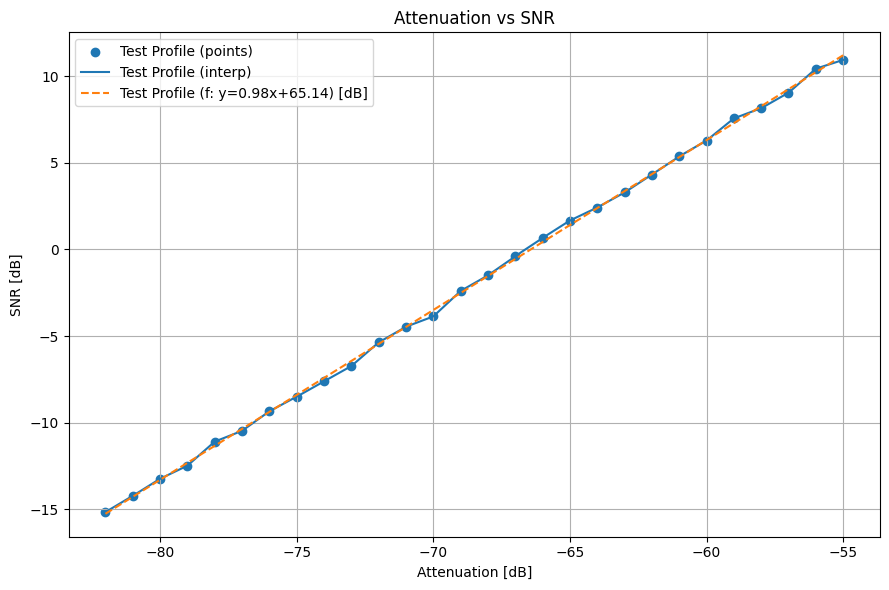

In [2]:
import src.core.snr_utils as snr_utils

profile = snr_utils.SDRProfile.load("tests/test_profile.json")
print(f"[INFO] Loaded profile: {profile.name}")
print(f"[INFO] PHY parameters: {profile.phy_params}")
print(f"[INFO] Frame parameters: {profile.frame_params}")
print(f"[INFO] Fold Mode: {profile.fold_mode}")
print(f"[INFO] SDR Tx Parameters: {profile.tx_sdr_params}")
print(f"[INFO] SDR Rx Parameters: {profile.rx_sdr_params}")
print(f"[INFO] Timestamp: {profile.timestamp}")
snr_utils.plot_profile_snr_map(profile, show_regression=True)

## Anexo: Efectos de la Saturación


Si la atenuación es demasiado baja, la señal transmitida llegará con una magnitud excesivamente alta al receptor. En ese caso, el ADC puede saturarse: las muestras superarán el rango de entrada permitido y serán recortadas (“clipped”) a la excursión máxima del dispositivo.

Este efecto de clipping distorsiona fuertemente la señal y puede afectar tanto la sincronización como la estimación de SNR ya que detecta al clipping como parte del ruido, por lo que debe evitarse.

[WARN - PHY LoRA params] samples_per_chip > 2 is not standard. This may lead to unexpected results in some cases. (FPA and CPA folding may not work as expected)


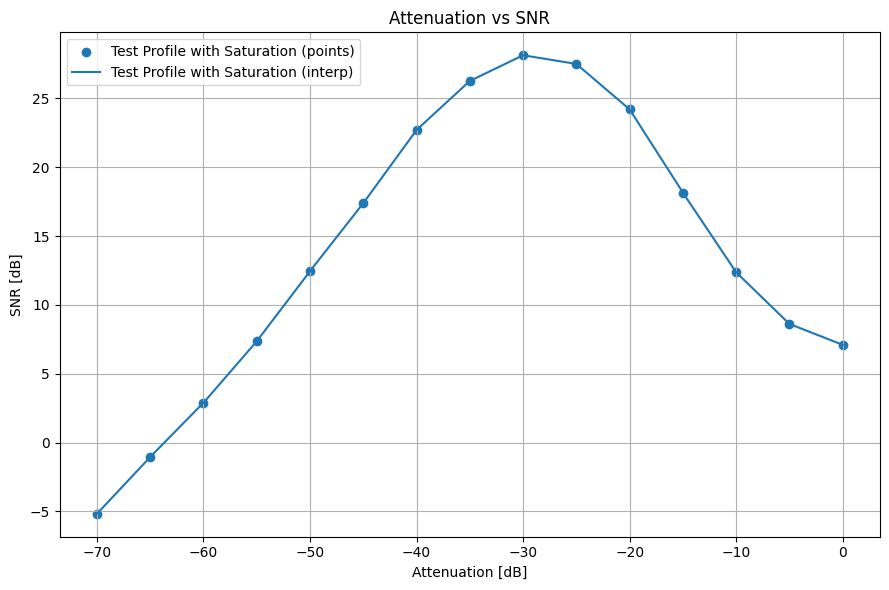

In [3]:
profile = snr_utils.SDRProfile.load("tests/test_profile_with_saturation.json")
snr_utils.plot_profile_snr_map(profile, show_regression=False)